         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-09-28  234.05  235.95  230.20  233.50  233.75               3069914   
1  2018-09-27  234.55  236.80  231.10  233.80  233.25               5082859   
2  2018-09-26  240.00  240.00  232.50  235.00  234.25               2240909   
3  2018-09-25  233.30  236.75  232.00  236.25  236.10               2349368   
4  2018-09-24  233.55  239.20  230.75  234.00  233.30               3423509   

   Turnover (Lacs)  
0          7162.35  
1         11859.95  
2          5248.60  
3          5503.90  
4          7999.55  


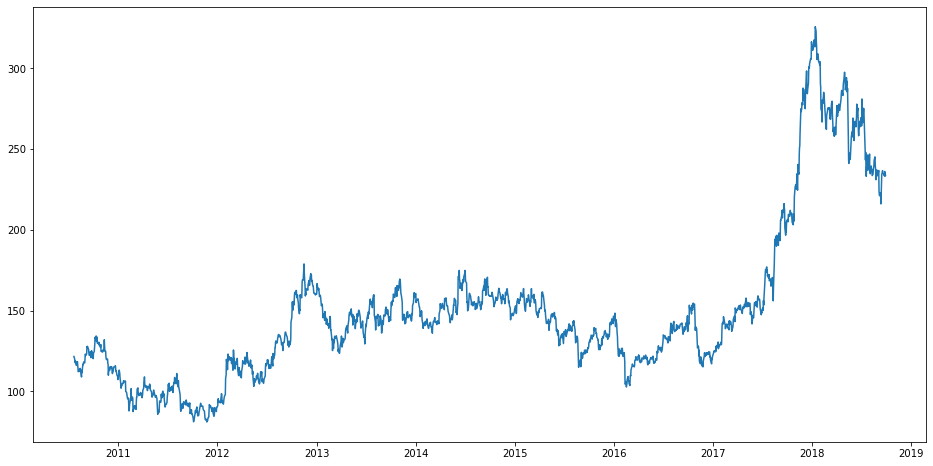

957/957 - 53s - loss: 9.0085e-04


<ipython-input-2-2f344cb74088>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_closing_price


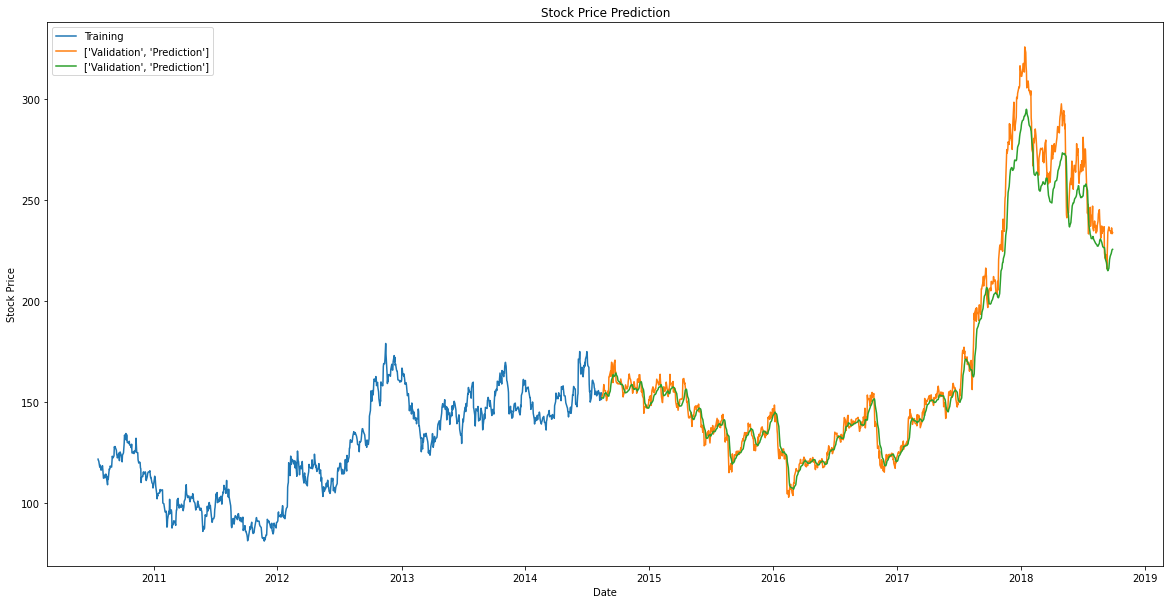

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv")
print(df.head())

df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df['Date']
plt.figure(figsize=(16, 8))
plt.plot(df["Close"], label='Close Price history')
plt.show()

data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close"][i] = data["Close"][i]

scaler = MinMaxScaler(feature_range=(0, 1))
final_dataset = new_dataset.values
train_data = final_dataset[0:1017, :]
valid_data = final_dataset[1017:, :]
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis=1, inplace=True)
final_dataset = new_dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)
x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i - 60:i, 0])
    y_train_data.append(scaled_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)

X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i - 60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

lstm_model.save("saved_model.h5")

train_data = new_dataset[:1017]
valid_data = new_dataset[1017:]
valid_data['Predictions'] = predicted_closing_price
plt.plot(train_data["Close"], label='Training')
plt.plot(valid_data[['Close', "Predictions"]], label=['Validation', 'Prediction'])
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()